In [2]:
from google.colab import files
uploaded = files.upload()

Saving convolutional_models.py to convolutional_models.py
Saving sequential_models.py to sequential_models.py
Saving unet_parts.py to unet_parts.py


In [3]:
uploaded = files.upload()

Saving reverb_dataset.py to reverb_dataset.py
Saving utils.py to utils.py


In [4]:
!pip install soundfile
!pip install librosa==0.8.0
!pip install scipy==1.5.2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import librosa
import librosa.display as display
import soundfile as sf
import os
import torch
import cv2

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from utils import generate_spec, reconstruct_wave, graph_spec
from reverb_dataset import ReverbDataset
from convolutional_models import UNetRev, LateSupUnet

     |████████████████████████████████| 25.9MB 1.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
!pip install SciencePlots

  Created wheel for SciencePlots: filename=SciencePlots-1.0.7-cp37-none-any.whl size=5460 sha256=b5b4b300712078d7471f0c089b94df138084e75d6125ce657abe72b93b09ee55
  Stored in directory: /root/.cache/pip/wheels/65/01/f1/d910b2dd79844adab51de69f6f753cd10af4d0563e9ef19a24
Successfully built SciencePlots


In [ ]:
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apache2 | lighttpd | httpd poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arph

# Data

Need at least 16 GB RAM for the 4 tensors. You can generate the tensors with data_generation notebooks (Generate_spectrograms.ipynb and Normalize_spectrograms.ipynb)

Load a smaller file number (for train) if you have less RAM

In [ ]:
X_train1 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_train_1.pth')
X_train2 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_train_2.pth')
X_train3 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_train_3.pth')
X_train4 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_train_4.pth')
y_train1 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_train_1.pth')
y_train2 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_train_2.pth')
y_train3 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_train_3.pth')
y_train4 = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_train_4.pth')

In [ ]:
X = torch.cat((X_train1, X_train2, X_train3, X_train4))
y = torch.cat((y_train1, y_train2, y_train3, y_train4))

In [ ]:
total_dataset = ReverbDataset(X, y)
length_train = int(len(total_dataset)*0.85)
length_val = len(total_dataset) - length_train
lengths = [length_train, length_val]
dataset_train, dataset_val = random_split(total_dataset, lengths)

In [ ]:
print(len(dataset_train))
print(len(dataset_val))

17000
3000


# Training

In [ ]:
def trainer(model, train_loader, val_loader, checkpoints, nEpochs = 100, lr = 1e-3):
  """
  Train model

  model: U-net model on GPU
  train_loader: dataloader containing train examples
  val_loader: dataloader containing validation examples
  checkpoints: list of directories to save the model, train loss and Val loss respectively
  """

  criterion = nn.MSELoss()
  beta1 = 0.5
  beta2 = 0.999
  lr_decay = 0.97
  decay_rate = 2

  optimizer = torch.optim.Adam(model.parameters(), lr, (beta1, beta2))

  train_loss = []
  val_loss = []
  
  model.train()
  for epoch in range(nEpochs):
    temp_train_loss = 0.0
    corrects_train = 0
    for i, (rev_data, clean_data) in enumerate(train_loader):
      rev_data = rev_data.cuda()
      clean_data = clean_data.cuda()

      optimizer.zero_grad()
      output = model(rev_data)
      loss_train = criterion(output, clean_data)
      loss_train.backward()
      optimizer.step()

      temp_train_loss += loss_train.item()/len(train_loader)

    temp_val_loss = 0.0    
    #Validacion
    model.eval()
    with torch.no_grad():
      for i, (rev_data, clean_data) in enumerate(val_loader):
        rev_data = rev_data.cuda()
        clean_data = clean_data.cuda()
        output = model(rev_data)
        loss_val = criterion(output, clean_data)
        temp_val_loss += loss_val.item()/len(val_loader)

    train_loss.append(temp_train_loss)
    val_loss.append(temp_val_loss)

    print('Epoch : {} || Train Loss: {:.3f} || Val Loss: {:.3f}'\
         .format(epoch+1, loss_train.item(), loss_val.item()))
    model.train()
    
    if ((epoch+1)%5 == 0):
      torch.save(model.state_dict(), checkpoints[0])
      torch.save(train_loss, checkpoints[1])
      torch.save(val_loss, checkpoints[2])
      print("saved models")

    if (epoch % decay_rate == 1):
       optimizer.param_groups[0]['lr'] *= lr_decay

  return train_loss, val_loss

In [ ]:
train_loader = DataLoader(dataset_train, batch_size = 16, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(dataset_val, batch_size = 16, shuffle = True, num_workers = 4, pin_memory = True)

In [ ]:
net = LateSupUnet(n_channels=1, bilinear=False).cuda()
checkpoints = ['/content/drive/My Drive/data_audio/models/LateSupUnet_state_dict.pth', '/content/drive/My Drive/data_audio/losses/train_loss_LateSupUnet.pth', 
               '/content/drive/My Drive/data_audio/losses/val_loss_LateSupUnet.pth']
train_loss, val_loss = trainer(net, train_loader, val_loader, checkpoints, lr=2e-4, nEpochs = 50)

Epoch : 1 || Train Loss: 41.006 || Val Loss: 35.352
Epoch : 2 || Train Loss: 17.001 || Val Loss: 16.422
Epoch : 3 || Train Loss: 20.498 || Val Loss: 19.210
Epoch : 4 || Train Loss: 21.641 || Val Loss: 16.793
Epoch : 5 || Train Loss: 13.491 || Val Loss: 16.485
saved models
Epoch : 6 || Train Loss: 22.904 || Val Loss: 19.769
Epoch : 7 || Train Loss: 28.665 || Val Loss: 17.324
Epoch : 8 || Train Loss: 14.929 || Val Loss: 14.508
Epoch : 9 || Train Loss: 13.096 || Val Loss: 16.623
Epoch : 10 || Train Loss: 19.966 || Val Loss: 15.004
saved models
Epoch : 11 || Train Loss: 14.136 || Val Loss: 17.351
Epoch : 12 || Train Loss: 15.602 || Val Loss: 17.443
Epoch : 13 || Train Loss: 11.445 || Val Loss: 11.755
Epoch : 14 || Train Loss: 13.148 || Val Loss: 15.438
Epoch : 15 || Train Loss: 11.329 || Val Loss: 15.214
saved models
Epoch : 16 || Train Loss: 14.145 || Val Loss: 15.432
Epoch : 17 || Train Loss: 13.117 || Val Loss: 15.024
Epoch : 18 || Train Loss: 10.187 || Val Loss: 14.046
Epoch : 19 || Tr

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


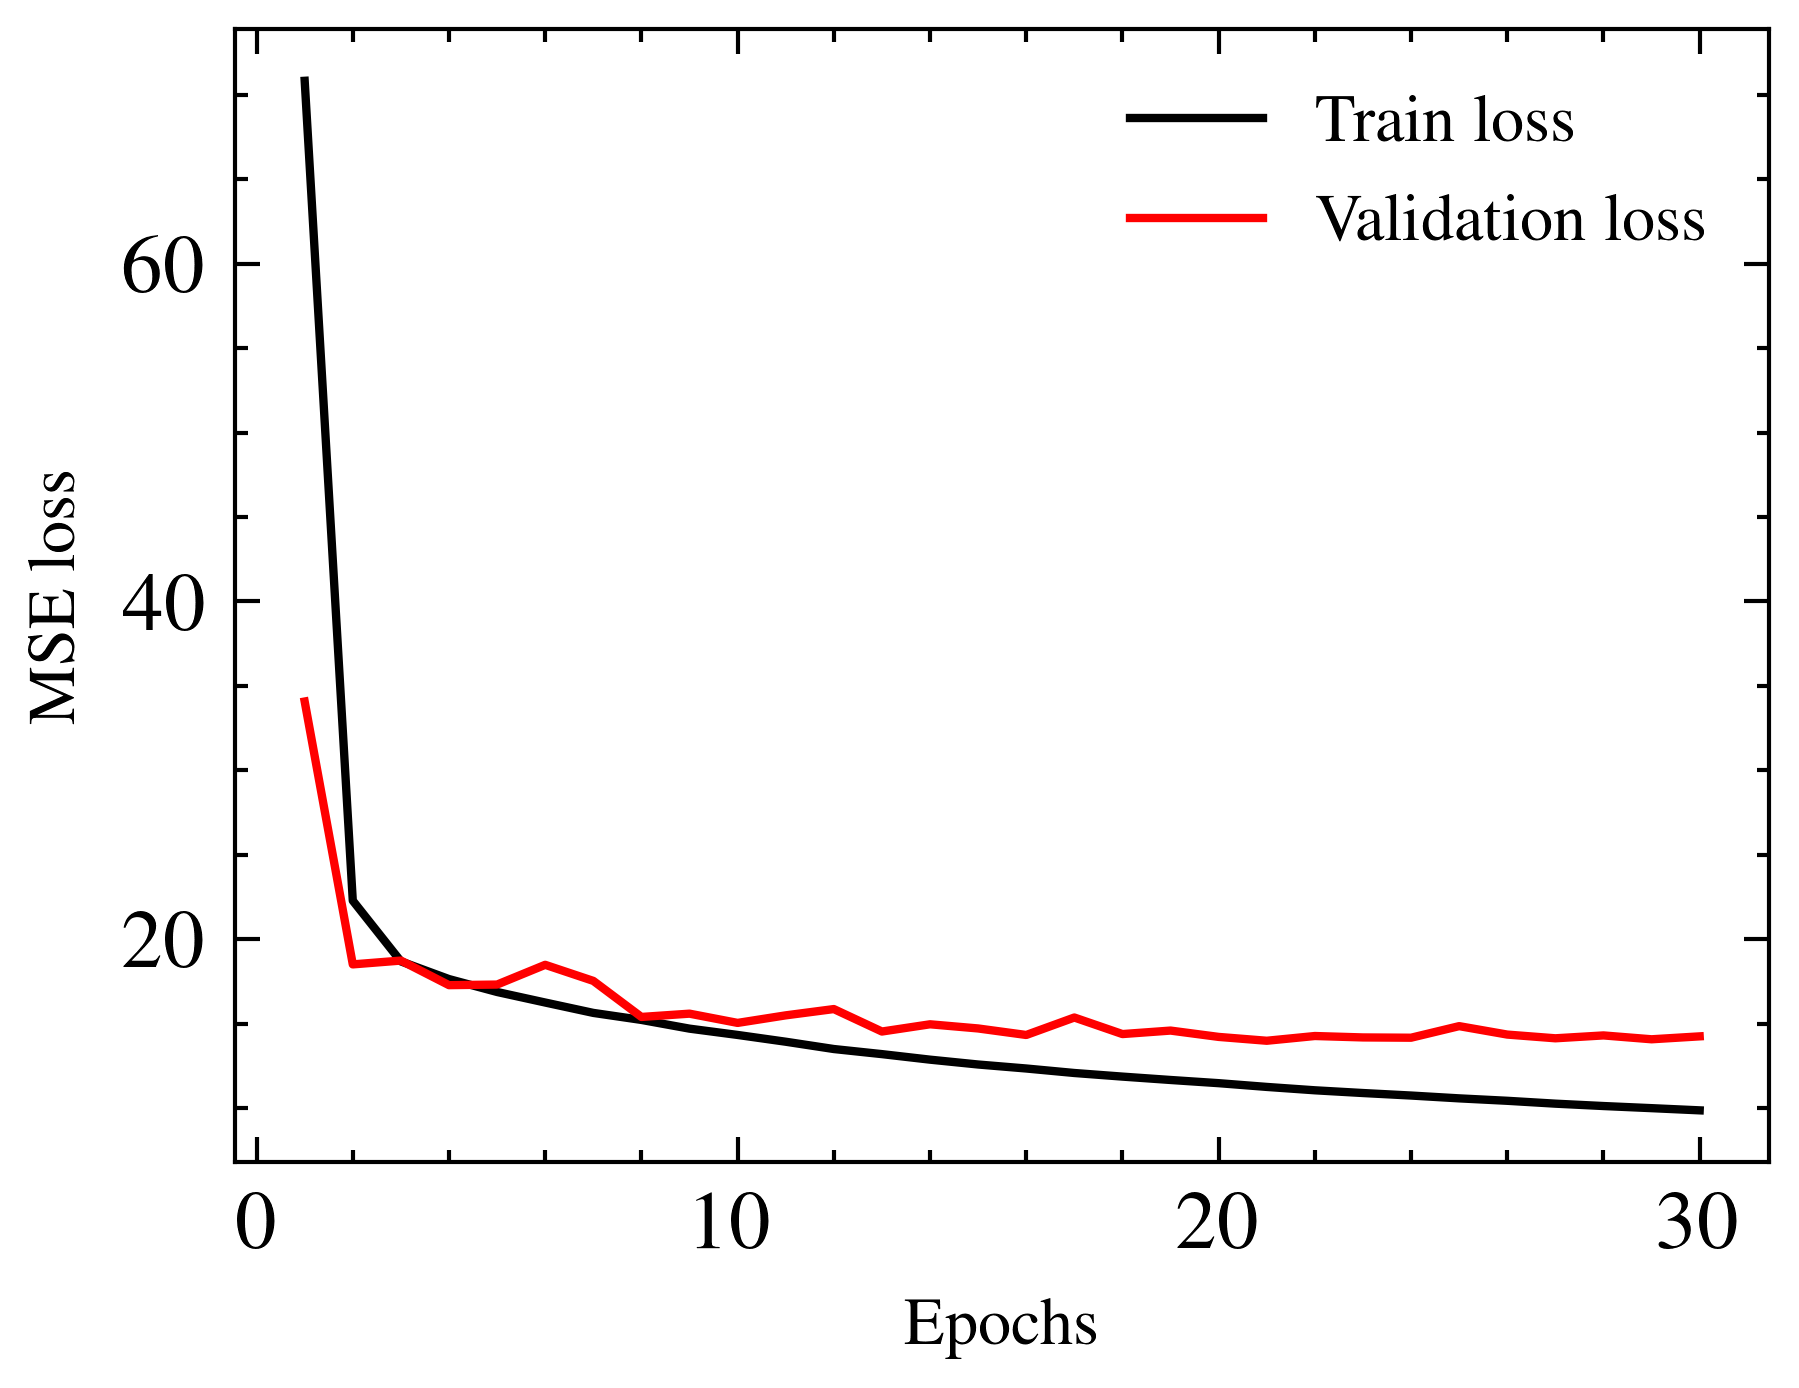

In [ ]:
plt.style.reload_library()
plt.style.use(['science', 'ieee'])
train_loss = torch.load('/content/drive/My Drive/data_audio/losses/train_loss_LateSupUnet.pth')
val_loss = torch.load('/content/drive/My Drive/data_audio/losses/val_loss_LateSupUnet.pth')

matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
plt.figure()
plt.rcParams["font.family"] = "serif"
plt.plot(np.arange(1, 31, 1), train_loss, '-', label = 'Train loss')
plt.plot(np.arange(1, 31, 1), val_loss, '-', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.legend()

# Qualitative Evaluation

In [5]:
def evaluate_qualitative_realdata(model_G, audio_path, num_example, speech_rate=16000):
  """
  net: Unet generator model on CPU
  audio_dirs: list of directories containing reverberant spectrograms, clean spectrograms,
              reverberant waveforms and clean waveforms respectively
  num_example: example number in data
  speech_rate: sampling rate of speech data  
  """
  
  matplotlib.rc('xtick', labelsize=15) 
  matplotlib.rc('ytick', labelsize=15)
  matplotlib.rcParams.update({'font.size': 15})

  waves = torch.load(audio_path)
  rev_spec = generate_spec(waves[num_example], speech_rate)
  original_size = rev_spec.shape

  example = torch.tensor(rev_spec[None, None, :, :], dtype = torch.float32)
  model_G.eval()
  derev = model_G(example)

  derev = derev.clone().detach().cpu().numpy()
  derev = derev[0, 0, :, :]
  derev = cv2.resize(derev, dsize = (original_size[1], original_size[0]), interpolation = cv2.INTER_LANCZOS4)

  graph_spec(rev_spec)
  graph_spec(derev)


def evaluate_qualitative(model_G, audio_dirs, num_example, speech_rate=16000):
  """
  net: Unet model on CPU
  audio_dirs: list of directories containing reverberant spectrograms, clean spectrograms,
              reverberant waveforms and clean waveforms respectively
  num_example: example number in data
  speech_rate: sampling rate of speech data  
  """
  
  matplotlib.rc('xtick', labelsize=15) 
  matplotlib.rc('ytick', labelsize=15)
  matplotlib.rcParams.update({'font.size': 15})
  plt.rcParams["font.family"] = "serif"

  X_test = torch.load(audio_dirs[0])
  y_test = torch.load(audio_dirs[1])
  waves = torch.load(audio_dirs[2])
  waves_target = torch.load(audio_dirs[3])
  dataset_test = ReverbDataset(X_test, y_test)

  original_spec = generate_spec(waves[num_example], speech_rate)
  clean_spec = generate_spec(waves_target[num_example], speech_rate)
  original_size = original_spec.shape

  original_spec = generate_spec(waves[num_example], speech_rate)
  clean_spec = generate_spec(waves_target[num_example], speech_rate)
  original_size = original_spec.shape

  example = dataset_test.__getitem__(num_example)[0]
  rev_spec = example.numpy()
  example = torch.tensor(rev_spec[None, :, :, :], dtype=torch.float32)
  model_G.eval()
  derev = model_G(example)

  derev = derev.clone().detach().cpu().numpy()
  derev = derev[0, 0, :, :]
  derev = cv2.resize(derev, dsize = (original_size[1], original_size[0]), interpolation = cv2.INTER_LANCZOS4)

  graph_spec(original_spec)
  graph_spec(clean_spec)
  graph_spec(derev)

In [8]:
model_unet = LateSupUnet(n_channels=1, bilinear=False)
model_unet.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/LateSupUnet_state_dict.pth', map_location=lambda storage, loc: storage))
dir_list = ['/content/drive/My Drive/data_audio/non_norm_data/X_test.pth', '/content/drive/My Drive/data_audio/non_norm_data/y_test.pth',
            '/content/drive/My Drive/data_audio/non_norm_data/waverev.pth', '/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth']

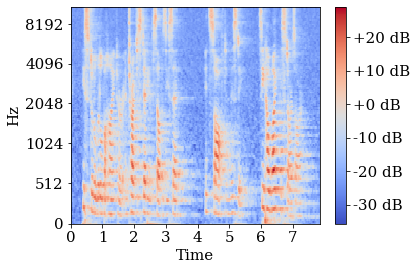

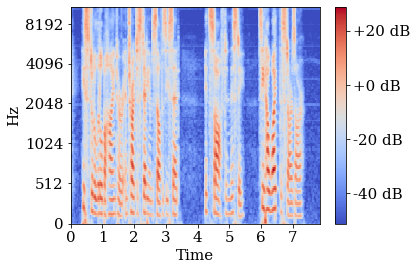

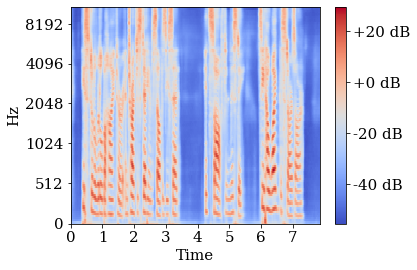

In [9]:
evaluate_qualitative(model_unet, dir_list, 100)

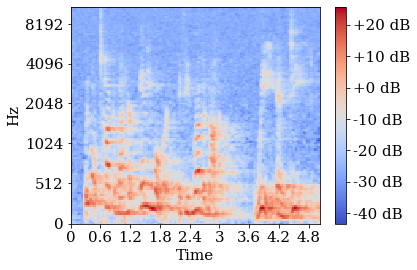

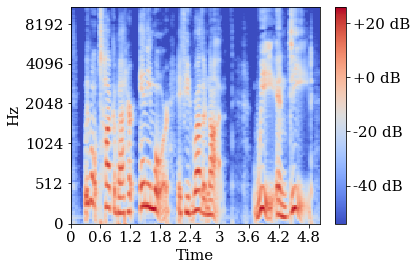

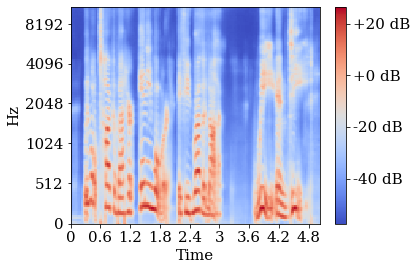

In [10]:
evaluate_qualitative(model_unet, dir_list, 300)

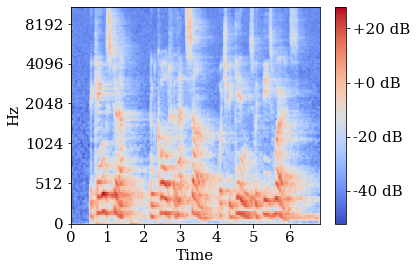

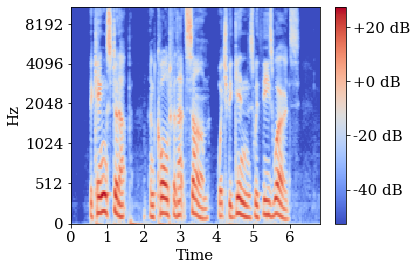

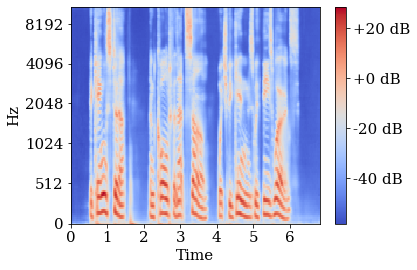

In [11]:
evaluate_qualitative(model_unet, dir_list, 400)

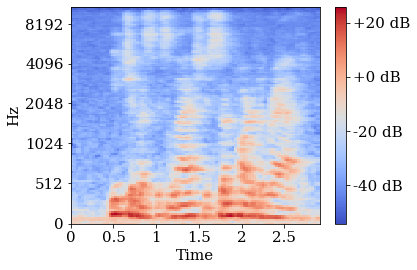

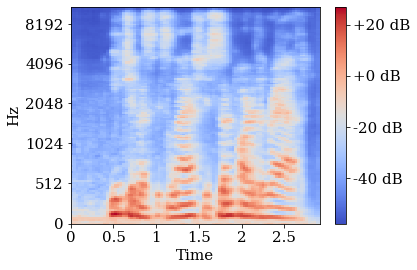

In [12]:
path = '/content/drive/My Drive/real_data/waves2'
model_G = LateSupUnet(n_channels=1, bilinear=False)
model_G.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/LateSupUnet_state_dict.pth', map_location=lambda storage, loc: storage))
evaluate_qualitative_realdata(model_G, path, 452)

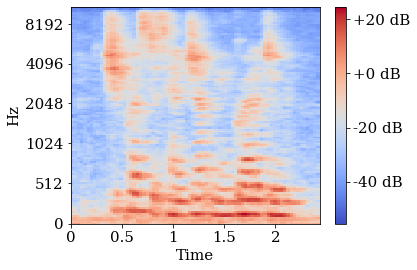

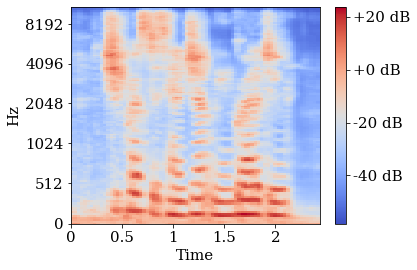

In [13]:
path = '/content/drive/My Drive/real_data/waves2'
model_G = LateSupUnet(n_channels=1, bilinear=False)
model_G.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/LateSupUnet_state_dict.pth', map_location=lambda storage, loc: storage))
evaluate_qualitative_realdata(model_G, path, 15)

# Quantitative Evaluation

In [ ]:
!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip

     / 2.1MB 2.6MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     - 92kB 70.5MB/s
     / 327kB 19.7MB/s
     | 65.6MB 3.4MB/s
     |████████████████████████████████| 163kB 10.2MB/s 
  Created wheel for pysepm: filename=pysepm-0.1-cp37-none-any.whl size=24291 sha256=8b906177aedc1949c92f11d81e57fd6f63acc09f4129ff671330b0bf226a742f
  Stored in directory: /tmp/pip-ephem-wheel-cache-4t5354dg/wheels/17/75/23/17712e0da834688ac430e0cf826dd1f7450d0b4873e0269f7c
Successfully built pysepm
  Created wheel for SRMRpy: filename=SRMRpy-1.0-cp37-none-any.whl size=9397 sha256=baa0aac2899a89f69580fc62324b92a5b4d2ee3a7bb13b62a847436778ec1c05
  Stored in directory: /tmp/pip-ephem-wheel-cache-4t5354dg/wheels/ef/f1/00/7c2aef84fdfd2c195486371d26b18f72c5bda5fe8442ef4c00
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7781 sha256=c6ae2464bbd4ac72f7262283381d356845d45a6fd7052d5a3aecec89a91d0158
  St

In [ ]:
!pip install pystoi
!pip install pypesq
from pysepm import llr, cepstrum_distance, fwSNRseg, srmr 
from pystoi import stoi
from pypesq import pesq

  Created wheel for pypesq: filename=pypesq-1.2.4-cp37-cp37m-linux_x86_64.whl size=84224 sha256=4af545a75abb73e7c4f789d949a0913aca619b2f7ee53be2c22f38d5fddd41a0
  Stored in directory: /root/.cache/pip/wheels/c9/29/a6/ed19583426cffac50b3e75160f894120a49f9bafa585a2edbe
Successfully built pypesq


In [ ]:
def evaluate(net, dataset, path, path_waves, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = False):
  """
  net: U-net model used 
  dataset: reverb_dataset object to extract examples
  path: base directory to save results
  path_waves: directory containing reverb waveforms (not recovered from spectrograms)
  init_example: first example in dataset to be considered
  end_example: last example in dataset to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """

  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))

  if (initial):
    reverb_pesq_list = []
    reverb_stoi_list = []
    reverb_llr_list = []
    reverb_cd_list = []
    reverb_fwSNRseg_list = []
    reverb_srmr_list = []

    dereverb_pesq_list = []
    dereverb_stoi_list = []
    dereverb_llr_list = []
    dereverb_cd_list = []
    dereverb_fwSNRseg_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_pesq_list = torch.load(path + 'reverb_pesq_SupUnet.pth')
    reverb_stoi_list = torch.load(path + 'reverb_stoi_SupUnet.pth')
    reverb_llr_list = torch.load(path + 'reverb_llr_SupUnet.pth')
    reverb_cd_list = torch.load(path + 'reverb_cd_SupUnet.pth')
    reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_SupUnet.pth')
    reverb_srmr_list = torch.load(path + 'reverb_srmr_SupUnet.pth')

    dereverb_pesq_list = torch.load(path + 'dereverb_pesq_SupUnet.pth')
    dereverb_stoi_list = torch.load(path + 'dereverb_stoi_SupUnet.pth')
    dereverb_llr_list = torch.load(path + 'dereverb_llr_SupUnet.pth')
    dereverb_cd_list = torch.load(path + 'dereverb_cd_SupUnet.pth')
    dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_SupUnet.pth')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_SupUnet.pth')
  
  waves = torch.load(path_waves)
  net.eval()
  for i in range(init_example, end_example):
    print("Processing Example n°{}".format(i+1))
    real_spec = generate_spec(waves[i], speech_rate)
    rev_spec, clean_spec = dataset.__getitem__(i)
    clean_spec = clean_spec[0, :, :]
    net_input = torch.zeros((1, 1, rev_spec.shape[1], rev_spec.shape[2]))

    if normalize_data:
      norm_example, norm_stats_rev = linear_scaler(rev_spec[0, :, :].numpy())
      net_input[0, 0, :, :] = torch.tensor(norm_example)
      net_response = net(net_input.to(device))
      net_response = net_response.clone().detach().cpu().numpy() if torch.cuda.is_available() else net_response.clone().detach().numpy()
      net_response = (net_response-norm_stats_rev[1])/norm_stats_rev[0]


    else:
      net_input[0, :, :, :] = rev_spec
      net_response = net(net_input.to(device))
      net_response = net_response.clone().detach().cpu().numpy() if torch.cuda.is_available() else net_response.clone().detach().numpy()
  
    
    try:
      net_response = net_response[0, 0, :, :]
      recon_spec = cv2.resize(net_response, dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)
      clean_spec = cv2.resize(clean_spec.numpy(), dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)
      rev_spec = cv2.resize(rev_spec[0, :, :].numpy(), dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)

      original = reconstruct_wave(clean_spec)
      reverb = reconstruct_wave(rev_spec)
      recon = reconstruct_wave(recon_spec)
      recon_srmr = recon

      pesq_metric_rev = pesq(original[0:len(reverb)], reverb, fs = speech_rate)
      stoi_metric_rev = stoi(original[0:len(reverb)], reverb, speech_rate)
      llr_metric_rev = llr(original[0:len(reverb)], reverb, speech_rate)
      cd_metric_rev = cepstrum_distance(original[0:len(reverb)], reverb, speech_rate)
      fwSNRseg_metric_rev = fwSNRseg(original[0:len(reverb)], reverb, speech_rate)
      srmr_metric_rev = srmr(waves[i], speech_rate)

      pesq_metric_recon = pesq(original[0:len(recon)], recon, fs = speech_rate)
      stoi_metric_recon = stoi(original[0:len(recon)], recon, speech_rate)
      llr_metric_recon = llr(original[0:len(recon)], recon, speech_rate)
      cd_metric_recon = cepstrum_distance(original[0:len(recon)], recon, speech_rate)
      fwSNRseg_metric_recon = fwSNRseg(original[0:len(recon)], recon, speech_rate)
      srmr_metric_recon = srmr(recon_srmr, speech_rate)

      reverb_pesq_list.append(pesq_metric_rev)
      reverb_stoi_list.append(stoi_metric_rev)
      reverb_llr_list.append(llr_metric_rev)
      reverb_cd_list.append(cd_metric_rev)
      reverb_fwSNRseg_list.append(fwSNRseg_metric_rev)
      reverb_srmr_list.append(srmr_metric_rev)

      dereverb_pesq_list.append(pesq_metric_recon)
      dereverb_stoi_list.append(stoi_metric_recon)
      dereverb_llr_list.append(llr_metric_recon)
      dereverb_cd_list.append(cd_metric_recon)
      dereverb_fwSNRseg_list.append(fwSNRseg_metric_recon)
      dereverb_srmr_list.append(srmr_metric_recon)

      print('PESQ reverberated signal: {:.3f} || PESQ dereverberated signal: {:.3f}'.format(pesq_metric_rev, pesq_metric_recon))
      print('STOI reverberated signal: {:.3f} || STOI dereverberated signal: {:.3f}'.format(stoi_metric_rev, stoi_metric_recon))
      print('LLR reverberated signal: {:.3f} || LLR dereverberated signal: {:.3f}'.format(llr_metric_rev, llr_metric_recon))
      print('CD reverberated signal: {:.3f} || CD dereverberated signal: {:.3f}'.format(cd_metric_rev, cd_metric_recon))
      print('fwSNRseg reverberated signal: {:.3f} || fwSNRseg dereverberated signal: {:.3f}'.format(fwSNRseg_metric_rev, fwSNRseg_metric_recon))
      print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
      print('\n')
    except librosa.feature.inverse.ParameterError: 
      pass

    if ((i+1)%10 == 0):
      torch.save(reverb_pesq_list, path + 'reverb_pesq_SupUnet.pth')
      torch.save(reverb_stoi_list, path + 'reverb_stoi_SupUnet.pth')
      torch.save(reverb_llr_list, path + 'reverb_llr_SupUnet.pth')
      torch.save(reverb_cd_list, path + 'reverb_cd_SupUnet.pth')
      torch.save(reverb_fwSNRseg_list, path + 'reverb_fwSNRseg_SupUnet.pth')
      torch.save(reverb_srmr_list, path + 'reverb_srmr_SupUnet.pth')

      torch.save(dereverb_pesq_list, path + 'dereverb_pesq_SupUnet.pth')
      torch.save(dereverb_stoi_list, path + 'dereverb_stoi_SupUnet.pth')
      torch.save(dereverb_llr_list, path + 'dereverb_llr_SupUnet.pth')
      torch.save(dereverb_cd_list, path + 'dereverb_cd_SupUnet.pth')
      torch.save(dereverb_fwSNRseg_list, path + 'dereverb_fwSNRseg_SupUnet.pth')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_SupUnet.pth')
      
      print('Saved')
      print('\n')

# Simulated Room 1

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room1/'
path_waves = '/content/drive/My Drive/data_audio/non_norm_data/waverev.pth'
X_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_test.pth')
y_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_test.pth')
model_unet = LateSupUnet(n_channels=1, bilinear=False)
model_unet.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/LateSupUnet_state_dict.pth', map_location=lambda storage, loc: storage))
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 0, 500, initial = True, normalize_data=False)

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room1/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_SupUnet.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_SupUnet.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_SupUnet.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_SupUnet.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_SupUnet.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_SupUnet.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_SupUnet.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_SupUnet.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_SupUnet.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_SupUnet.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_SupUnet.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_SupUnet.pth')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.02
STOI: 0.75
LLR: 0.78
CD: 5.30
fwSNRseg: 7.12
SRMR: 3.17

Dereverberated signal:
PESQ: 2.72
STOI: 0.86
LLR: 0.42
CD: 3.61
fwSNRseg: 10.14
SRMR: 6.42


# Simulated Room 2

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
path_waves = '/content/drive/My Drive/data_audio/non_norm_data/waverev_2.pth'
X_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_test_2.pth')
y_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_test_2.pth')
model_unet = LateSupUnet(n_channels=1, bilinear=False)
model_unet.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/LateSupUnet_state_dict.pth', map_location=lambda storage, loc: storage))
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
PESQ reverberated signal: 2.118 || PESQ dereverberated signal: 2.295
STOI reverberated signal: 0.584 || STOI dereverberated signal: 0.622
LLR reverberated signal: 1.011 || LLR dereverberated signal: 0.718
CD reverberated signal: 5.844 || CD dereverberated signal: 4.852
fwSNRseg reverberated signal: 7.034 || fwSNRseg dereverberated signal: 7.527
SRMR reverberated signal: 2.991 || SRMR dereverberated signal: 3.140


Processing Example n°2
PESQ reverberated signal: 2.153 || PESQ dereverberated signal: 2.370
STOI reverberated signal: 0.603 || STOI dereverberated signal: 0.626
LLR reverberated signal: 0.992 || LLR dereverberated signal: 0.699
CD reverberated signal: 5.511 || CD dereverberated signal: 4.671
fwSNRseg reverberated signal: 6.605 || fwSNRseg dereverberated signal: 7.182
SRMR reverberated signal: 2.799 || SRMR dereverberated signal: 2.924


Processing Example n°3
PESQ reverberated signal: 2.041 || PESQ dereverberated signal: 2.229
STOI r

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
path_waves = '/content/drive/My Drive/data_audio/non_norm_data/waverev_2.pth'
X_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_test_2.pth')
y_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_test_2.pth')
model_unet = LateSupUnet(n_channels=1, bilinear=False)
model_unet.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/LateSupUnet_state_dict.pth', map_location=lambda storage, loc: storage))
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 390, 500, initial = False, normalize_data=False)

Current device: cpu
Processing Example n°391
PESQ reverberated signal: 2.083 || PESQ dereverberated signal: 2.422
STOI reverberated signal: 0.609 || STOI dereverberated signal: 0.680
LLR reverberated signal: 0.975 || LLR dereverberated signal: 0.637
CD reverberated signal: 5.530 || CD dereverberated signal: 4.417
fwSNRseg reverberated signal: 5.963 || fwSNRseg dereverberated signal: 7.055
SRMR reverberated signal: 4.923 || SRMR dereverberated signal: 5.790


Processing Example n°392
PESQ reverberated signal: 2.169 || PESQ dereverberated signal: 2.437
STOI reverberated signal: 0.607 || STOI dereverberated signal: 0.665
LLR reverberated signal: 0.973 || LLR dereverberated signal: 0.589
CD reverberated signal: 5.172 || CD dereverberated signal: 4.241
fwSNRseg reverberated signal: 5.480 || fwSNRseg dereverberated signal: 6.995
SRMR reverberated signal: 4.837 || SRMR dereverberated signal: 5.362


Processing Example n°393
PESQ reverberated signal: 2.117 || PESQ dereverberated signal: 2.411


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_SupUnet.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_SupUnet.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_SupUnet.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_SupUnet.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_SupUnet.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_SupUnet.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_SupUnet.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_SupUnet.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_SupUnet.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_SupUnet.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_SupUnet.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_SupUnet.pth')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.07
STOI: 0.60
LLR: 0.92
CD: 5.53
fwSNRseg: 6.62
SRMR: 4.49

Dereverberated signal:
PESQ: 2.36
STOI: 0.66
LLR: 0.64
CD: 4.59
fwSNRseg: 7.63
SRMR: 5.36


# Simulated Room 3

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/'
path_waves = '/content/drive/My Drive/data_audio/non_norm_data/waverev_3.pth'
X_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_test_3.pth')
y_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_test_3.pth')
model_unet = LateSupUnet(n_channels=1, bilinear=False)
model_unet.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/LateSupUnet_state_dict.pth', map_location=lambda storage, loc: storage))
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 0, 500, initial = True, normalize_data=False)

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_SupUnet.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_SupUnet.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_SupUnet.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_SupUnet.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_SupUnet.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_SupUnet.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_SupUnet.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_SupUnet.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_SupUnet.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_SupUnet.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_SupUnet.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_SupUnet.pth')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.38
STOI: 0.78
LLR: 0.79
CD: 5.12
fwSNRseg: 8.35
SRMR: 5.21

Dereverberated signal:
PESQ: 2.74
STOI: 0.82
LLR: 0.52
CD: 4.09
fwSNRseg: 9.32
SRMR: 5.73


# Simulated Room 4

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/'
path_waves = '/content/drive/My Drive/data_audio/non_norm_data/waverev_4.pth'
X_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_test_4.pth')
y_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_test_4.pth')
model_unet = LateSupUnet(n_channels=1, bilinear=False)
model_unet.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/LateSupUnet_state_dict.pth', map_location=lambda storage, loc: storage))
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
PESQ reverberated signal: 2.219 || PESQ dereverberated signal: 2.680
STOI reverberated signal: 0.759 || STOI dereverberated signal: 0.857
LLR reverberated signal: 0.488 || LLR dereverberated signal: 0.325
CD reverberated signal: 4.188 || CD dereverberated signal: 3.104
fwSNRseg reverberated signal: 7.388 || fwSNRseg dereverberated signal: 9.897
SRMR reverberated signal: 2.446 || SRMR dereverberated signal: 5.495


Processing Example n°2
PESQ reverberated signal: 2.362 || PESQ dereverberated signal: 2.797
STOI reverberated signal: 0.782 || STOI dereverberated signal: 0.867
LLR reverberated signal: 0.539 || LLR dereverberated signal: 0.294
CD reverberated signal: 4.502 || CD dereverberated signal: 3.062
fwSNRseg reverberated signal: 7.694 || fwSNRseg dereverberated signal: 10.343
SRMR reverberated signal: 2.231 || SRMR dereverberated signal: 4.348


Processing Example n°3
PESQ reverberated signal: 2.114 || PESQ dereverberated signal: 2.627
STOI 

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/'
path_waves = '/content/drive/My Drive/data_audio/non_norm_data/waverev_4.pth'
X_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_test_4.pth')
y_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_test_4.pth')
model_unet = LateSupUnet(n_channels=1, bilinear=False)
model_unet.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/LateSupUnet_state_dict.pth', map_location=lambda storage, loc: storage))
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 490, 500, initial = False, normalize_data=False)

Current device: cpu
Processing Example n°491
PESQ reverberated signal: 2.099 || PESQ dereverberated signal: 2.768
STOI reverberated signal: 0.713 || STOI dereverberated signal: 0.839
LLR reverberated signal: 0.597 || LLR dereverberated signal: 0.295
CD reverberated signal: 4.736 || CD dereverberated signal: 3.015
fwSNRseg reverberated signal: 7.358 || fwSNRseg dereverberated signal: 10.859
SRMR reverberated signal: 2.193 || SRMR dereverberated signal: 3.958


Processing Example n°492
PESQ reverberated signal: 2.210 || PESQ dereverberated signal: 2.746
STOI reverberated signal: 0.740 || STOI dereverberated signal: 0.849
LLR reverberated signal: 0.570 || LLR dereverberated signal: 0.355
CD reverberated signal: 4.465 || CD dereverberated signal: 3.292
fwSNRseg reverberated signal: 7.667 || fwSNRseg dereverberated signal: 10.076
SRMR reverberated signal: 2.437 || SRMR dereverberated signal: 3.920


Processing Example n°493
PESQ reverberated signal: 2.232 || PESQ dereverberated signal: 2.80

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_SupUnet.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_SupUnet.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_SupUnet.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_SupUnet.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_SupUnet.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_SupUnet.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_SupUnet.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_SupUnet.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_SupUnet.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_SupUnet.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_SupUnet.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_SupUnet.pth')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.07
STOI: 0.77
LLR: 0.59
CD: 4.73
fwSNRseg: 7.08
SRMR: 3.15

Dereverberated signal:
PESQ: 2.72
STOI: 0.87
LLR: 0.34
CD: 3.23
fwSNRseg: 10.20
SRMR: 5.98


# Simulated Room 5

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room5/'
path_waves = '/content/drive/My Drive/data_audio/non_norm_data/waverev_5.pth'
X_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/X_test_5.pth')
y_test = torch.load('/content/drive/My Drive/data_audio/non_norm_data/y_test_5.pth')
model_unet = LateSupUnet(n_channels=1, bilinear=False)
model_unet.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/LateSupUnet_state_dict.pth', map_location=lambda storage, loc: storage))
dataset_test = ReverbDataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 0, 500, initial = True, normalize_data=False)

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room5/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_SupUnet.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_SupUnet.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_SupUnet.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_SupUnet.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_SupUnet.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_SupUnet.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_SupUnet.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_SupUnet.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_SupUnet.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_SupUnet.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_SupUnet.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_SupUnet.pth')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 1.90
STOI: 0.72
LLR: 1.31
CD: 7.11
fwSNRseg: 6.34
SRMR: 3.08

Dereverberated signal:
PESQ: 2.65
STOI: 0.84
LLR: 0.59
CD: 4.38
fwSNRseg: 9.56
SRMR: 6.30


# Retransmitted/Real data

In [ ]:
def evaluate_realdata(net, paths_data, path, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = False):
  """
  net: U-net model to evaluate
  X_test: tensor containing reverberant spectrograms (real data, not simulated)
  path: base directory to save results
  path_data: list of 2 strings representing 2 directories containing reverb waveforms and tensor with spectrograms
  init_example: first example in dataset to be considered
  end_example: last exalple in dataset to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """

  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))

  path_spec = paths_data[0]
  path_wave = path_data[1]

  if (initial):
    reverb_srmr_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_srmr_list = torch.load(path + 'reverb_srmr_SupUnet.pth')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_SupUnet.pth')
  
  X_test = torch.load(path_spec)
  waves = torch.load(path_wave)
  net.eval()
  for i in range(init_example, end_example):
    print("Processing Example n°{}".format(i+1))
    rev_spec = torch.clone(X_test[i, :, :, :])
    net_input = torch.zeros((1, 1, rev_spec.shape[1], rev_spec.shape[2]))

    if normalize_data:
      norm_example, norm_stats_rev = linear_scaler(rev_spec[0, :, :].numpy())
      #norm_example, norm_stats_rev = normalize(rev_spec[0, :, :].numpy())
      net_input[0, 0, :, :] = torch.tensor(norm_example)
      net_response = net(net_input.to(device))
      net_response = net_response.clone().detach().cpu().numpy() if torch.cuda.is_available() else net_response.clone().detach().numpy()
      net_response = (net_response-norm_stats_rev[1])/norm_stats_rev[0]
      #net_response = net_response*(norm_stats_rev[1] + 1e-6) + norm_stats_rev[0]

    else:
      net_input[0, :, :, :] = rev_spec
      net_response = net(net_input.to(device))
      net_response = net_response.clone().detach().cpu().numpy() if torch.cuda.is_available() else net_response.clone().detach().numpy()
  
    
    try:
      net_response = net_response[0, 0, :, :]
      real_spec = generate_spec(waves[i], speech_rate)
      resize_spec = cv2.resize(net_response, dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)
      recon = reconstruct_wave(resize_spec)

      srmr_metric_rev = srmr(waves[i], speech_rate)
      srmr_metric_recon = srmr(recon, speech_rate)
     
      reverb_srmr_list.append(srmr_metric_rev)
      dereverb_srmr_list.append(srmr_metric_recon)

      print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
      print('\n')
    except librosa.feature.inverse.ParameterError: 
      pass

    if ((i+1)%10 == 0):
 
      torch.save(reverb_srmr_list, path + 'reverb_srmr_SupUnet.pth')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_SupUnet.pth')
      
      print('Saved')
      print('\n')

# Near Microphones data

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/'
path_data = ['/content/drive/My Drive/real_data/X_test_real1', '/content/drive/My Drive/real_data/waves1']
model_unet = LateSupUnet(n_channels=1, bilinear=False)
model_unet.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/LateSupUnet_state_dict.pth', map_location=lambda storage, loc: storage))
evaluate_realdata(model_unet, path_data, path, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
SRMR reverberated signal: 2.644 || SRMR dereverberated signal: 2.360


Processing Example n°2
SRMR reverberated signal: 2.455 || SRMR dereverberated signal: 3.452


Processing Example n°3
SRMR reverberated signal: 3.125 || SRMR dereverberated signal: 2.789


Processing Example n°4
SRMR reverberated signal: 2.727 || SRMR dereverberated signal: 2.447


Processing Example n°5
SRMR reverberated signal: 2.833 || SRMR dereverberated signal: 3.457


Processing Example n°6
SRMR reverberated signal: 3.089 || SRMR dereverberated signal: 4.052


Processing Example n°7
SRMR reverberated signal: 2.542 || SRMR dereverberated signal: 3.857


Processing Example n°8
SRMR reverberated signal: 2.694 || SRMR dereverberated signal: 3.876


Processing Example n°9
SRMR reverberated signal: 2.502 || SRMR dereverberated signal: 3.155


Processing Example n°10
SRMR reverberated signal: 4.001 || SRMR dereverberated signal: 4.330


Saved


Processing Example n°11
SRMR re

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_SupUnet.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_SupUnet.pth')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
SRMR: 3.99

Dereverberated signal:
SRMR: 5.34


# Far microphones data

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/'
path_data = ['/content/drive/My Drive/real_data/X_test_real2', '/content/drive/My Drive/real_data/waves2']
model_unet = LateSupUnet(n_channels=1, bilinear=False)
model_unet.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/LateSupUnet_state_dict.pth', map_location=lambda storage, loc: storage))
evaluate_realdata(model_unet, path_data, path, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
SRMR reverberated signal: 3.544 || SRMR dereverberated signal: 6.525


Processing Example n°2
SRMR reverberated signal: 5.083 || SRMR dereverberated signal: 6.468


Processing Example n°3
SRMR reverberated signal: 4.067 || SRMR dereverberated signal: 6.780


Processing Example n°4
SRMR reverberated signal: 3.647 || SRMR dereverberated signal: 5.176


Processing Example n°5
SRMR reverberated signal: 5.406 || SRMR dereverberated signal: 6.895


Processing Example n°6
SRMR reverberated signal: 3.478 || SRMR dereverberated signal: 5.196


Processing Example n°7
SRMR reverberated signal: 5.542 || SRMR dereverberated signal: 7.096


Processing Example n°8
SRMR reverberated signal: 2.970 || SRMR dereverberated signal: 5.326


Processing Example n°9
SRMR reverberated signal: 7.028 || SRMR dereverberated signal: 7.474


Processing Example n°10
SRMR reverberated signal: 5.625 || SRMR dereverberated signal: 9.648


Saved


Processing Example n°11
SRMR re

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_SupUnet.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_SupUnet.pth')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
SRMR: 4.36

Dereverberated signal:
SRMR: 6.56
